In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import common_corpus, common_dictionary, common_texts
from gensim.models import LdaModel
from collections import Counter, defaultdict

In [2]:
np.random.seed(1)

In [3]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [4]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [5]:
dict(common_dictionary)

{0: 'computer',
 1: 'human',
 2: 'interface',
 3: 'response',
 4: 'survey',
 5: 'system',
 6: 'time',
 7: 'user',
 8: 'eps',
 9: 'trees',
 10: 'graph',
 11: 'minors'}

In [6]:
lda = LdaModel(corpus=common_corpus, num_topics=3, id2word=common_dictionary)

In [7]:
lda.get_topics()

array([[0.09991315, 0.03180536, 0.03219635, 0.08912607, 0.17471717,
        0.09523831, 0.09889168, 0.08675566, 0.03297976, 0.03802519,
        0.11181334, 0.10853791],
       [0.11099348, 0.19903353, 0.11578164, 0.03308505, 0.03267179,
        0.20439455, 0.03299609, 0.03511733, 0.11463977, 0.04719991,
        0.03913659, 0.03495036],
       [0.03130063, 0.02087262, 0.07347195, 0.08797028, 0.03108724,
        0.0874393 , 0.08150668, 0.1444235 , 0.07367393, 0.16928692,
        0.12514158, 0.07382545]], dtype=float32)

In [8]:
topic_names = [lda.id2word[i] for i in range(len(lda.id2word))]

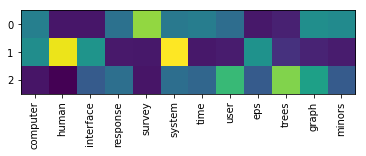

In [9]:
fig, ax = plt.subplots()
ax.imshow(lda.get_topics())
ax.set_xticks(np.arange(len(lda.id2word)))
ax.set_xticklabels(topic_names, rotation = 'vertical')
None

In [10]:
lda.get_topics().sum(axis=1)

array([1.       , 1.       , 1.0000001], dtype=float32)

In [11]:
lda.print_topics()

[(0,
  '0.175*"survey" + 0.112*"graph" + 0.109*"minors" + 0.100*"computer" + 0.099*"time" + 0.095*"system" + 0.089*"response" + 0.087*"user" + 0.038*"trees" + 0.033*"eps"'),
 (1,
  '0.204*"system" + 0.199*"human" + 0.116*"interface" + 0.115*"eps" + 0.111*"computer" + 0.047*"trees" + 0.039*"graph" + 0.035*"user" + 0.035*"minors" + 0.033*"response"'),
 (2,
  '0.169*"trees" + 0.144*"user" + 0.125*"graph" + 0.088*"response" + 0.087*"system" + 0.082*"time" + 0.074*"minors" + 0.074*"eps" + 0.073*"interface" + 0.031*"computer"')]

## Trying out collapsed gibbs

In [12]:
vocab_size = max(max(1 + v[0] for v in doc) for doc in common_corpus)
vocab_size

12

In [13]:
doc_lengths = [sum(x[1] for x in doc) for doc in common_corpus]
corpus_length = sum(doc_lengths)

In [14]:
doc_lengths

[3, 6, 4, 4, 3, 1, 2, 3, 3]

In [15]:
corpus_length

29

In [16]:
K = 3

In [17]:
# Initialization
Z = [np.random.choice(K, size=L) for L in doc_lengths]
Z

[array([0, 2, 2]),
 array([0, 1, 1, 2, 1, 2]),
 array([0, 1, 1, 0]),
 array([1, 1, 2, 2]),
 array([0, 2, 0]),
 array([2]),
 array([0, 2]),
 array([2, 0, 2]),
 array([0, 2, 0])]

In [18]:
burn_in = 10
lag = 20
num_samples = 100

In [19]:
import copy

In [20]:
import itertools

In [21]:
def flatten_one_level(L):
    return list(itertools.chain.from_iterable(L))

In [22]:
flatten_one_level([[1,2,3],[4,5,6],[7,8],[],[9]])

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
from tqdm import tqdm, tnrange

In [24]:
np.random.seed(1)

In [29]:
class CollapsedGibbs(object):
    def fit(self, corpus, num_topics, vocab_size, burn_in = 10, lag = 20, num_samples = 100, alpha = 1.0, beta = 1.0):
        alpha = np.broadcast_to(alpha, (num_topics,))
        beta = np.broadcast_to(beta, (vocab_size,))
        beta_sum = beta.sum()
        lag = max(1, lag)
        burn_in = max(0, burn_in)
        num_samples = max(0, num_samples)

        doc_lengths = [sum(x[1] for x in doc) for doc in corpus]
        corpus_expanded = [flatten_one_level([w[0]] * w[1] for w in doc) for doc in corpus]
        Z = [np.zeros(L, dtype='int') for L in doc_lengths]

        counts_doc_topic = defaultdict(lambda: np.zeros((num_topics,)))
        counts_vocab_topic = defaultdict(lambda: np.zeros((num_topics,)))
        counts_topic = np.zeros((num_topics,))

        def sample_once(doc_index, pos_index, Zold):
            nonlocal counts_doc_topic, counts_vocab_topic, counts_topic
            v = corpus_expanded[doc_index][pos_index]
            adjust = np.zeros(num_topics)
            A = counts_doc_topic[doc_index]
            B = counts_vocab_topic[v]
            C = counts_topic
            if Zold is not None:
                adjust[Zold] = -1
                A = A.copy() + adjust
                B = B.copy() + adjust
                C = C.copy() + adjust
            probs = (alpha + A) * (beta[v] + B) / (beta_sum + C)
            probs /= probs.sum()
            Znew = np.random.choice(num_topics, p = probs)
            if Znew != Zold:
                Z[doc_index][pos_index] = Znew
                adjust[Znew] = 1
                counts_doc_topic[doc_index] += adjust
                counts_vocab_topic[v] += adjust
                counts_topic += adjust
        
        for di in range(len(corpus_expanded)):
            for pi in range(doc_lengths[di]):
                sample_once(doc_index = di, pos_index = pi, Zold = None)
        del di, pi
        
        self.samples = []
        for i in tnrange(burn_in + lag * num_samples):
            for doc_index in range(len(Z)):
                for pos_index in range(doc_lengths[doc_index]):
                    Zold = Z[doc_index][pos_index]
                    Znew = sample_once(doc_index, pos_index, Zold = Zold)

            if i >= burn_in and (i - burn_in) % lag == 0:
                self.samples.append(copy.deepcopy(Z))

        self.corpus = copy.deepcopy(corpus)
        self.corpus_expanded = corpus_expanded
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.alpha = alpha.copy()
        self.beta = beta.copy()

    def topics_by_sample(self):
        counts = np.zeros((len(self.samples), self.num_topics, self.vocab_size))
        for si, sample in enumerate(self.samples):
            for di, doc in enumerate(sample):
                for pi, z in enumerate(doc):
                    w = self.corpus_expanded[di][pi]
                    counts[si, z, w] += 1
        numer = counts + self.beta[np.newaxis, np.newaxis, :]
        denom = counts.sum(axis = 2, keepdims = True) + self.beta.sum()
        return numer / denom
        #return counts / counts.sum(axis = 2, keepdims = True)

    def topics(self):
        counts = np.zeros((self.num_topics, self.vocab_size))
        for sample in self.samples:
            for di, doc in enumerate(sample):
                for pi, z in enumerate(doc):
                    w = self.corpus_expanded[di][pi]
                    counts[z, w] += 1
        numer = counts + self.beta[np.newaxis, :]
        denom = counts.sum(axis = 1, keepdims = True) + self.beta.sum()
        return numer / denom
        #return counts / counts.sum(axis = 1, keepdims = True)

In [30]:
result = CollapsedGibbs()
result.fit(common_corpus, num_topics = 3, vocab_size = vocab_size, num_samples = 100)
len(result.samples)

100

In [31]:
T = result.topics_by_sample()

In [32]:
nan_indices = np.array(np.where(np.isnan(T)))
if nan_indices.size > 0:
    example_index = nan_indices[0, 0]
else:
    example_index = 0

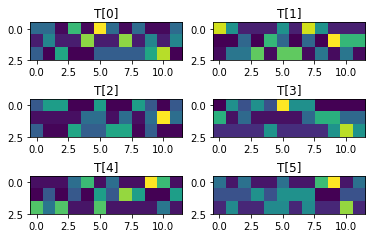

In [33]:
nr, nc = 3, 2
fig, ax = plt.subplots(nr, nc)
for i in range(nr * nc):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

In [34]:
sums = T.sum(axis=2)
np.min(sums), np.max(sums)

(0.9999999999999998, 1.0000000000000002)

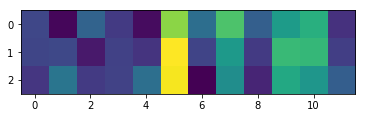

In [35]:
plt.imshow(T.mean(axis = 0));

In [36]:
topics = result.topics()

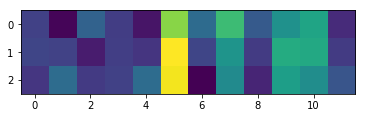

In [37]:
plt.imshow(topics);

In [38]:
from utils import niceprint

In [39]:
niceprint(topics)

[[0.0696 0.0532 0.0809 0.0686 0.0573 0.1269 0.0839 0.1146 0.0778 0.0983 0.1054 0.0635]
 [0.0711 0.0701 0.0591 0.0691 0.0661 0.1431 0.0711 0.0991 0.0681 0.1081 0.1071 0.0681]
 [0.0667 0.0844 0.0677 0.0698 0.0844 0.1417 0.0521 0.0958 0.0615 0.1031 0.0969 0.0760]]


In [40]:
[common_dictionary[i] for i in range(vocab_size)]

['computer',
 'human',
 'interface',
 'response',
 'survey',
 'system',
 'time',
 'user',
 'eps',
 'trees',
 'graph',
 'minors']

In [41]:
corpus_word_counts = Counter()
for doc in common_corpus:
    for w, c in doc:
        corpus_word_counts[w] += c
corpus_word_counts

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 2,
         5: 4,
         6: 2,
         7: 3,
         8: 2,
         9: 3,
         10: 3,
         11: 2})

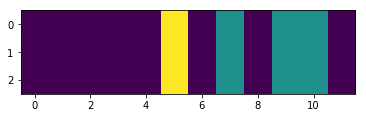

In [42]:
unif_topics = np.broadcast_to([corpus_word_counts[i] for i in range(vocab_size)], topics.shape).astype('float')
unif_topics /= unif_topics.sum(axis = 1, keepdims = True)
plt.imshow(unif_topics);

## Experiments with Griffiths-Steyvers square-image data generation

In [43]:
np.random.seed(1)

In [44]:
from sim_data import GriffithsSteyversSampler

In [45]:
sampler = GriffithsSteyversSampler(num_docs = 1000, words_per_doc = 100, dimension = 5, alpha = 0.1)
sampler.sample()
None

100%|██████████| 1000/1000 [00:07<00:00, 133.56it/s]


In [46]:
docs_to_display = 50

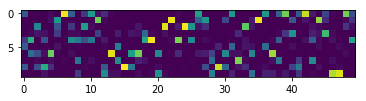

In [47]:
plt.imshow(np.array(sampler.doc_topic_mixtures)[:docs_to_display, :].T);

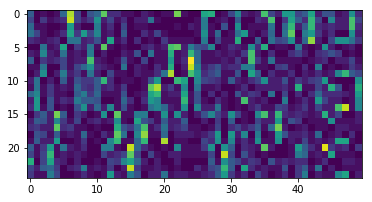

In [48]:
plt.imshow(sampler.data.toarray()[:docs_to_display, :].T);

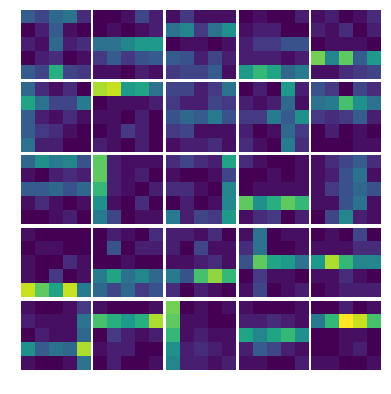

In [49]:
sq = 5
fig, ax = plt.subplots(sq, sq, figsize = (5, 5))
fig.subplots_adjust(hspace = 0.05, wspace = 0.05, left = 0, right = 1, top = 1, bottom = 0)
max_count = sampler.data[:docs_to_display, :].max()
for i in range(sq):
    for j in range(sq):
        n = i * sq + j
        if n < docs_to_display:
            X = sampler.data[n, :].toarray().reshape(sampler.dimension, sampler.dimension)
            ax[i, j].imshow(X, vmin = 0, vmax = max_count)
        ax[i, j].axis('off')

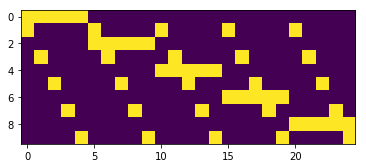

In [50]:
plt.imshow(sampler.topics);

In [51]:
%%time
lda = LdaModel(
    corpus=sampler.gensim_corpus,
    num_topics=sampler.num_topics,
    passes=20)

CPU times: user 24.9 s, sys: 131 ms, total: 25 s
Wall time: 25.2 s


In [52]:
topics = lda.get_topics()

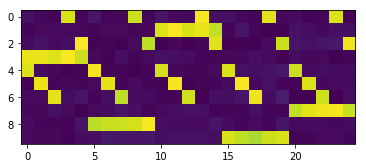

In [53]:
plt.imshow(topics);

In [54]:
np.random.seed(1)

In [55]:
result = CollapsedGibbs()
result.fit(
    corpus = sampler.gensim_corpus,
    num_topics = sampler.num_topics,
    vocab_size = sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

20

In [56]:
T = result.topics_by_sample()

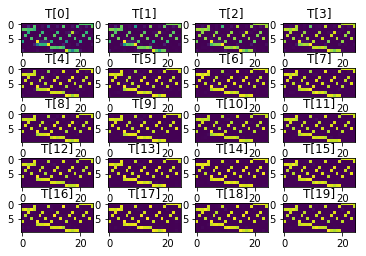

In [57]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

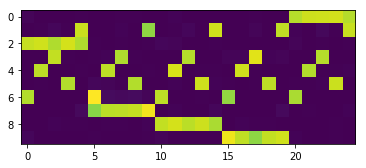

In [58]:
plt.imshow(result.topics());

In [59]:
# TODO: measure co-occurrence matrix; by sample, and overall?  (and put this into CollapsedGibbsSampler?)

In [60]:
%%time
cooccur_by_sample = []
for i, s in enumerate(result.samples):
    c = np.zeros((result.num_topics, result.num_topics))
    for di, d in enumerate(s):
        perm = np.random.permutation(len(d))
        for pi in range(0, len(d) - 1, 2):
            z1, z2 = d[perm[pi]], d[perm[pi + 1]]
            c[z1, z2] += 1
    c /= c.sum()
    cooccur_by_sample.append(c)

CPU times: user 1.61 s, sys: 49.1 ms, total: 1.66 s
Wall time: 1.62 s


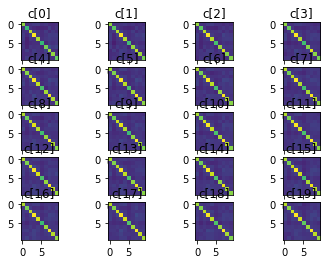

In [61]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(cooccur_by_sample[i], vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

In [62]:
from sim_data import topics_griffiths_steyvers

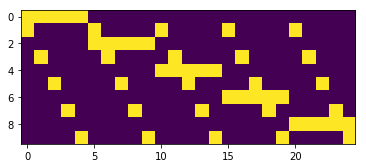

In [63]:
plt.imshow(topics_griffiths_steyvers(10));

### Try combining G.S. topics with tree-based model

In [87]:
import networkx as nx

In [88]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from sim_data import HPAM2Sampler, get_alpha
from functools import partial

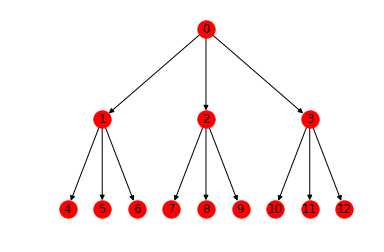

In [89]:
tree = make_tree([3,3])
nice_tree_plot(tree)

In [90]:
exact_topics = topics_griffiths_steyvers(tree.number_of_nodes())

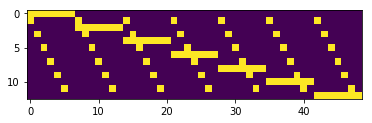

In [91]:
plt.imshow(exact_topics);

In [92]:
topic_func = lambda n: exact_topics[n, :]

In [93]:
np.random.seed(1)

In [94]:
h_sampler = HPAM2Sampler(
    tree,
    num_docs = 5000,
    words_per_doc = 500,
    vocab_size = exact_topics.shape[1],
    topic_dirichlet = None,
    topic_func = topic_func,
    alpha_func = partial(get_alpha, scale=0.1)
)

In [95]:
h_sampler.sample();

100%|██████████| 5000/5000 [04:29<00:00, 18.57it/s]


In [96]:
tree_corpus = []
for doc in h_sampler.docs:
    ctr = Counter(doc)
    doc_short = [(k, v) for k, v in ctr.items()]
    tree_corpus.append(doc_short)
len(tree_corpus)

5000

In [97]:
np.random.seed(3)
# NOTE: quality of results seem to have a lot of variance (to see this, try changing the random seed)

In [98]:
result = CollapsedGibbs()
result.fit(
    corpus = tree_corpus,
    num_topics = h_sampler.g.number_of_nodes(),
    vocab_size = h_sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

20

In [99]:
T = result.topics_by_sample()

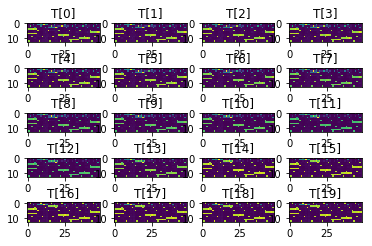

In [100]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

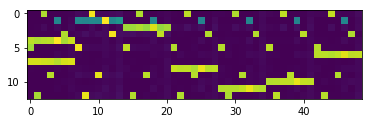

In [101]:
plt.imshow(T[-1]);

In [102]:
%%time
cooccur_by_sample = []
for i, s in enumerate(result.samples):
    c = np.zeros((result.num_topics, result.num_topics))
    for di, d in enumerate(s):
        perm = np.random.permutation(len(d))
        for pi in range(0, len(d) - 1, 2):
            z1, z2 = d[perm[pi]], d[perm[pi + 1]]
            c[z1, z2] += 1
    c /= c.sum()
    cooccur_by_sample.append(c)

CPU times: user 34.8 s, sys: 304 ms, total: 35.1 s
Wall time: 34.8 s


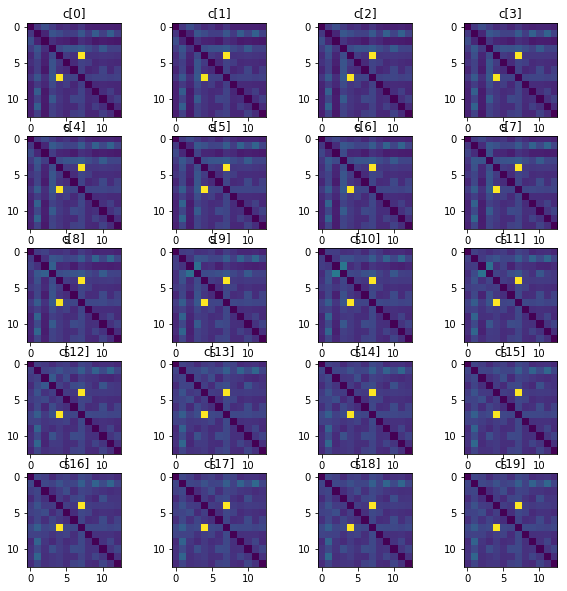

In [103]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc, figsize=(10,10))
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(without_diag(cooccur_by_sample[i]), vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

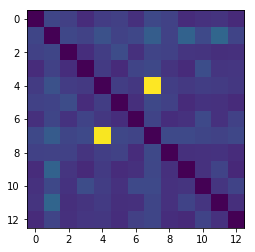

In [104]:
plt.imshow(without_diag(cooccur_by_sample[-1]), vmin=0);

In [105]:
from tree_extraction import Aho

In [106]:
tree_extracted = Aho.extract(cooccur_by_sample[-1])

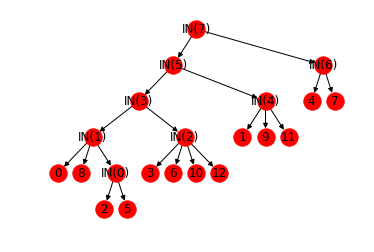

In [107]:
nice_tree_plot(tree_extracted)

In [108]:
r = without_diag(cooccur_by_sample[nr * nc - 1])
imax = np.argmax(r)
coordmax = np.unravel_index(imax, r.shape)
rmax = r[coordmax]
rmax, coordmax

(0.020792, (4, 7))

## Quick way to reload without rerunning everything

In [86]:
from importlib import reload
import sim_data
reload(sim_data)
del sim_data